In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
df = pd.read_csv('Datasets/all_diseases.csv.gz')
malaria = pd.read_csv('Datasets/malaria_data.csv.gz')

In [4]:
df.head()

,country,date,year,month,transmission_mode,no_cases,no_deaths,cumulative_cases,cumulative_deaths,disease,week
0,Afghanistan,2020-01-22,2020,1,air,0.0,0.0,0.0,0.0,covid-19,4
1,Afghanistan,2020-01-23,2020,1,air,0.0,0.0,0.0,0.0,covid-19,4
2,Afghanistan,2020-01-24,2020,1,air,0.0,0.0,0.0,0.0,covid-19,4
3,Afghanistan,2020-01-25,2020,1,air,0.0,0.0,0.0,0.0,covid-19,4
4,Afghanistan,2020-01-26,2020,1,air,0.0,0.0,0.0,0.0,covid-19,4


In [5]:
malaria_df = malaria[['date','cumulative_cases']].rename(columns = {'cumulative_cases': 'no_cases'})
malaria_df.date = pd.to_datetime(malaria_df.date)
malaria_df = malaria_df.groupby('date')['no_cases'].sum().to_frame()

In [6]:
malaria_df.head()

,no_cases
date,
2000-12-31,4910625.0
2001-12-31,5331273.0
2002-12-31,5054697.0
2003-12-31,7310187.0
2004-12-31,8851739.0


In [7]:
df.date = pd.to_datetime(df.date)

In [8]:
df = df[df.no_cases > 0]

In [9]:
non_covid = df[~df.disease.isin(['covid-19'])]

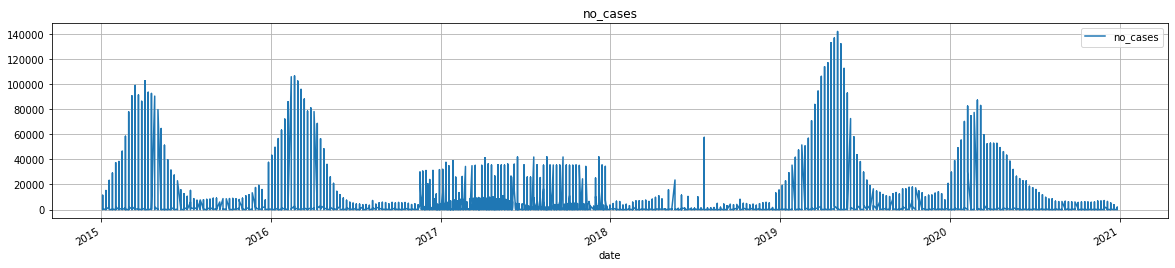

In [10]:
no_cases_plot = non_covid[['date','no_cases']].set_index('date')
no_cases_plot.plot(figsize=(20, 4))
plt.grid()
plt.legend(loc='best')
plt.title('no_cases')
plt.show(block=False)

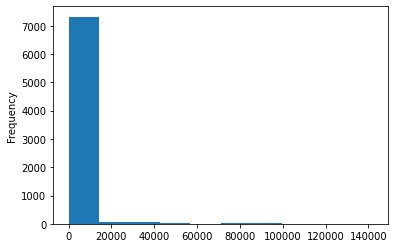

In [11]:
non_covid[~non_covid.disease.isin(['covid-19'])].no_cases.plot(kind='hist')

In [12]:
df.head()

,country,date,year,month,transmission_mode,no_cases,no_deaths,cumulative_cases,cumulative_deaths,disease,week
33,Afghanistan,2020-02-24,2020,2,air,1.0,0.0,1.0,0.0,covid-19,9
41,Afghanistan,2020-03-03,2020,3,air,1.0,0.0,2.0,0.0,covid-19,10
42,Afghanistan,2020-03-04,2020,3,air,2.0,0.0,4.0,0.0,covid-19,10
46,Afghanistan,2020-03-08,2020,3,air,1.0,0.0,5.0,0.0,covid-19,10
47,Afghanistan,2020-03-09,2020,3,air,2.0,0.0,7.0,0.0,covid-19,11


In [13]:
pivot_df = pd.pivot_table(df, 
                          index = df.date.dt.to_period('M'),
                          columns = 'disease', 
                          values ='no_cases', 
                          aggfunc = np.sum).fillna(0)

In [14]:
pivot_df.head()

disease,covid-19,dengue,zika
date,,,
2015-01,0.0,104982.0,0.0
2015-02,0.0,210751.0,0.0
2015-03,0.0,491597.0,0.0
2015-04,0.0,435122.0,0.0
2015-05,0.0,342184.0,0.0


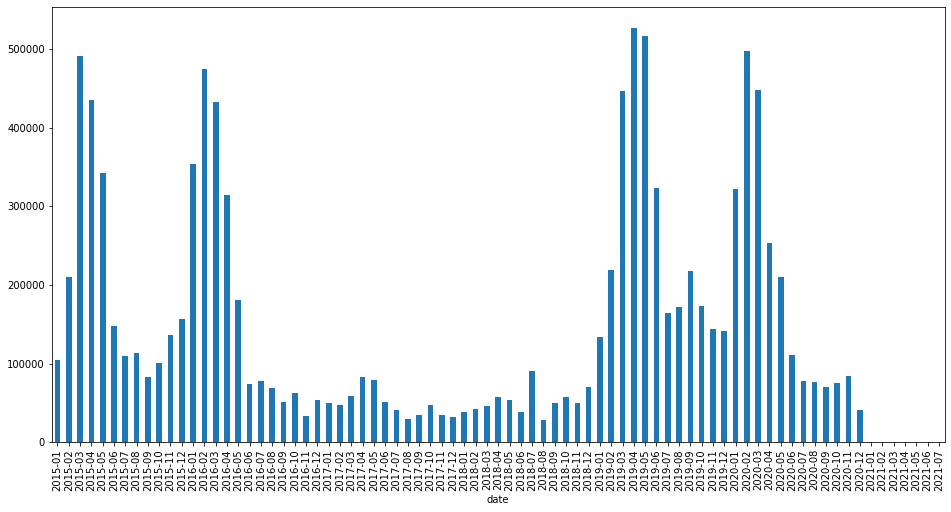

In [15]:
plt.figure(figsize=(16,8))
pivot_df.dengue.plot(kind='bar')

## Seeing Dengue cases over time to see if there are any trends....

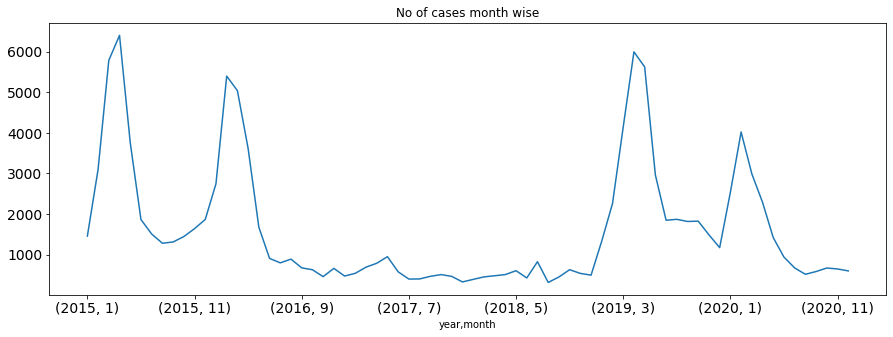

In [16]:
temp=df[df.disease.isin(['dengue'])].groupby(['year','month'])['no_cases'].mean()
temp.plot(figsize=(15,5), title= 'No of cases month wise', fontsize=14)

In [17]:
df.dtypes

country                      object
date                 datetime64[ns]
year                          int64
month                         int64
transmission_mode            object
no_cases                    float64
no_deaths                   float64
cumulative_cases            float64
cumulative_deaths           float64
disease                      object
week                          int64
dtype: object

In [18]:
pivot_df[pivot_df.dengue > 0 ].head()

disease,covid-19,dengue,zika
date,,,
2015-01,0.0,104982.0,0.0
2015-02,0.0,210751.0,0.0
2015-03,0.0,491597.0,0.0
2015-04,0.0,435122.0,0.0
2015-05,0.0,342184.0,0.0


In [19]:
pivot_df[pivot_df.dengue > 0 ].tail()

disease,covid-19,dengue,zika
date,,,
2020-08,34588598.0,76008.0,0.0
2020-09,43121892.0,69751.0,0.0
2020-10,77317934.0,75298.0,0.0
2020-11,141649488.0,84292.0,0.0
2020-12,195866349.0,40381.0,0.0


In [20]:
train = pivot_df.dengue.loc[: '2018-01']
train.index = pd.to_datetime(train.index.to_timestamp())
train = train.to_frame()

test = pivot_df.dengue.loc['2018-01':]
test.index = pd.to_datetime(test.index.to_timestamp())
test = test.to_frame()

In [21]:
train.head()

,dengue
date,
2015-01-01,104982.0
2015-02-01,210751.0
2015-03-01,491597.0
2015-04-01,435122.0
2015-05-01,342184.0


In [22]:
model = SimpleExpSmoothing(np.asarray(train.dengue))
fit1 = model.fit(smoothing_level = 0.6, optimized =False)

y = test.copy()
y['exponential_smoothing_value'] = fit1.forecast(len(test))

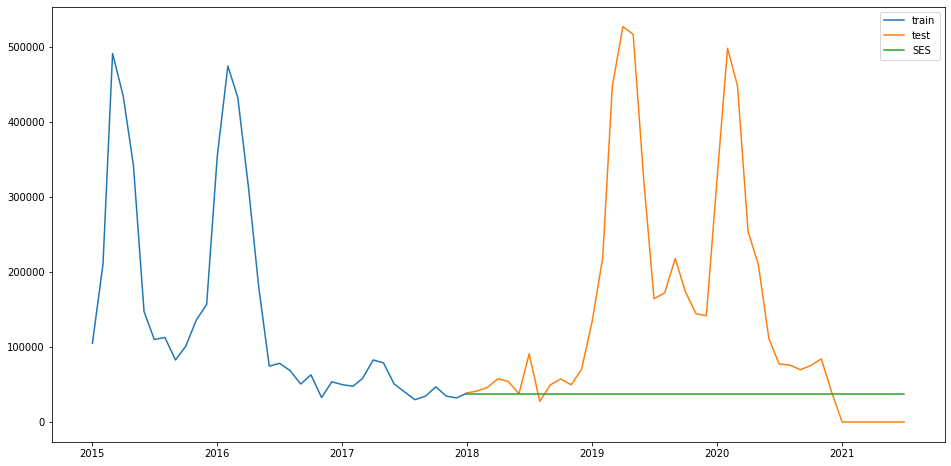

In [23]:
plt.figure(figsize=(16,8))
plt.plot(train['dengue'], label='train')
plt.plot(test['dengue'], label='test')
plt.plot(y['exponential_smoothing_value'], label='SES')
plt.legend(loc='best')
plt.show()

## combining Malaria data with others, and this has to be done on yearly basis only because the data is yearly for malaria

In [24]:
include_malaria_df = False

In [25]:
if include_malaria_df:
    all_df = pd.concat([df[['date','no_cases']], malaria_df.reset_index()])
    all_df['year'] = all_df.date.dt.year
else:
    all_df = df[['date','no_cases']]

In [26]:
all_df_f = all_df.groupby(all_df.date.dt.to_period('M'))['no_cases'].sum().to_frame()
all_df_f.index = pd.to_datetime(all_df_f.index.to_timestamp())

In [27]:
all_train = all_df_f.loc[: '2020-12']

all_test = all_df_f.loc['2020-12':]

In [28]:
all_model = SimpleExpSmoothing(np.asarray(all_train.no_cases))
all_fit1 = all_model.fit(smoothing_level = 0.6, optimized =False)

all_y = all_test.copy()
all_y['exponential_smoothing_value'] = all_fit1.forecast(len(all_test))

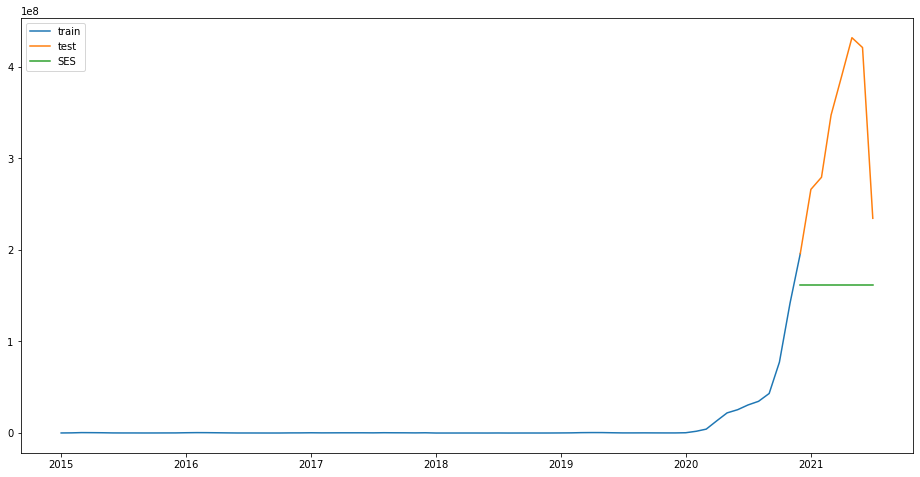

In [29]:
plt.figure(figsize=(16,8))
plt.plot(all_train['no_cases'], label='train')
plt.plot(all_test['no_cases'], label='test')
plt.plot(all_y['exponential_smoothing_value'], label='SES')
plt.legend(loc='best')
plt.show()